A Profit Model consists of 9 Variables
model = [e1, e2, e3, s1, s2, s3, p1, p2, p3]
with ei as the energy produced with plants of type i
     si as the planned amount of energy sold to market of type i
     pi as the price for market of type i
    
Plant Cost Model:
k : kWh per plant
c : cost per plant
m : maximum number of plants that can be used

with plant types:

In [1]:
# plant type 1
k1 =   50000
c1 =   10000
m1 =     100

# plant type 2
k2 =  600000
c2 =   80000
m2 =      50

# plant type 3
k3 = 4000000
c3 =  400000
m3 =       3

Market Model:
p : maximum price at which customers buy
d : maximum demand a customer would buy

with market types:

In [2]:
# market type 1
p1 =        0.45  # ct/kWh
d1 =  2000000     # kWh

# market type 2
p2 =        0.25
d2 = 30000000

# market type 3
p3 =        0.2
d3 = 20000000

In [3]:
import numpy as np 
import random as rnd
import copy
import matplotlib.pyplot as plt
import math
import operator

# online plotting
%matplotlib notebook  

# functions provided by N. Potyka
def demand(price, maxPrice, maxDemand):
    
    # if price is greater than max price, return 0
    if price > maxPrice:
        return 0
    
    # if product is free return maxDemand (ignore negative prices)
    if price <= 0:
        return maxDemand
    
    # else determine demand based on price using this function
    demand = maxDemand - price**2 * maxDemand / maxPrice**2
    
    return demand

def cost(x, kwhPerPlant, costPerPlant, maxPlants):
    
    # if x is non-positive, return 0
    if x <= 0:
        return 0
    
    # if x is greater than what can be generated return prohibitively large value
    if x > kwhPerPlant * maxPlants:
        LARGE = float('inf')  # (costPerPlant * maxPlants)*1000000
        return LARGE  # has to be defined
    
    # otherwise determine number of plants needed to generate x
    plantsNeeded = math.ceil(x / kwhPerPlant)
    
    # cost is number of plants needed times cost per plant
    return plantsNeeded * costPerPlant

In [4]:
def evaluation(model):
    # use the profit model to evaluate a model
    
    # kWh per plant needed for production cost calculation
    kwhPerPlant = [k1, k2, k3]
    # costs per plant needed for production cost calculation
    costsPerPlant = [c1, c2, c3]
    # max number of plants per plants needed for production cost calculation
    maxPlants = [m1, m2, m3]
    # current kWh cost price
    cost_price = 0.6
    # max demands needed for revenue calculation
    maxDemands = [d1, d2, d3]
    # max prices needed for revenue calculation
    maxPrices = [p1, p2, p3]
    
    productionCost = sum([cost(e,kWh,cPP,maxP) for e,kWh,cPP,maxP in zip(model[:3],kwhPerPlant,costsPerPlant,maxPlants)])
    purchasingCost = max(sum(model[3:6])-sum(model[:3]),0) * cost_price
    Cost = productionCost + purchasingCost
    Revenue = sum([min(demand(p,P,D),s)*p for s,p,D,P in zip(model[3:6],model[6:],maxDemands,maxPrices)])
    
    profit = Revenue - Cost
    
    return profit
    

In [5]:
def initialization(popSize = 10, mode='random'):
    
    # initialize empty population
    pop = []
    
    # choose a random value in respect to boundaries (random but edjucated)
    if mode == 'random':
        for i in range(popSize):
            # initialize empty model
            model = []
            # energy produced with plants of type 1
            model.append(rnd.randint(0, k1*m1)) 
            # energy produced with plants of type 2
            model.append(rnd.randint(0, k2*m2))
            # energy produced with plants of type 3
            model.append(rnd.randint(0, k3*m3))

            # planned amount of energy sold to market of type 1
            model.append(rnd.randint(0, d1))
            # planned amount of energy sold to market of type 2
            model.append(rnd.randint(0, d2))
            # planned amount of energy sold to market of type 3
            model.append(rnd.randint(0, d3))

            # tricky for working with floats
            #  price for market of type 1
            model.append(rnd.randrange(0, p1*100)/100)
            #  price for market of type 2
            model.append(rnd.randint(0, p2*100)/100)
            #  price for market of type 3
            model.append(rnd.randint(0, p3*100)/100)
            
            # add to population
            pop.append(model)
    
    return pop  # return initialized population

In [6]:
def donor_generation(target, otherPop, F, modeBase='random', modeDiff=1):
    # target is the current DE target
    # otherPop is the rest of the population excluding the target
    # F is the scaling factor
    
    # select a base vector base != target
    if modeBase=='random':
        b = rnd.randint(0,len(otherPop)-1)  # get random base index
    elif modeBase=='best':
        evals = [evaluation(x) for x in otherPop]
        b = evals.index(max(evals))  # get best base index
    base = otherPop[b]                # get base vector
    # remove base from the rest of the population
    otherPop.pop(b)
    
    # select two further different vectors
    x1 = rnd.randint(0,len(otherPop)-1)  # get vector 1 index
    v1 = otherPop[x1]                  # get vector 1
    # remove vector 1 from the rest of the population
    otherPop.pop(x1)
    
    x2 = rnd.randint(0,len(otherPop)-1)  # get vector 2 index
    v2 = otherPop[x2]                  # get vector 2
    
    # compute difference between v1 - v2
    diff = np.array(v1) - np.array(v2)
    
    if modeDiff==2:   #in case of two differences
        x3 = rnd.randint(0,len(otherPop)-1)  # get vector 3 index
        v3 = otherPop[x3] 
        otherPop.pop(x3)

        x4 = rnd.randint(0,len(otherPop)-1)  # get vector 4 index
        v4 = otherPop[x4] 
        
        diff += np.array(v3) - np.array(v4)
        
    # scale difference by scaling factor F
    scaled_diff = F*diff
    
    # add scaled difference to base
    donor = np.array(base) + scaled_diff
    
    # returns donor as a python list
    return donor.tolist()

In [7]:
def trial_generation(target, donor, CR):
    # target is the current target
    # donor is the current donor
    # CR is the crossover rate for the trial generation
    
    # generate trial vector z 
    z = []
    # pick r randomly to assure at least one mutation
    r = rnd.randint(0,len(target)-1)
    for i in range(len(target)):
        if rnd.random() <= CR or i == r:
            if donor[i] < 0:
                donor[i] = 0
            z.append(donor[i])
        else:
            if target[i] < 0:
                target[i] = 0
            z.append(target[i])
    
    return z

In [8]:
def trial_generator_exponential(target, donor, CR):
    # create a new trial vector z by using exponential crossover. 
    d = len(target)
    start_list = np.arange(0,d+1)
    start = rnd.choice(start_list)
    #z = []
    # choose L
    L = 0
    while rnd.uniform(0,1) < CR and L < d:
            L = L+1
            
    z = target[:start]+ target[start+L:]  
    z[start:start] = donor[start:start+L]
    # need to discuss if we need to include a +1
    
    for i in range(len(z)):
        if z[i] < 0:
            z[i] = 0
    return z

    Initialize population
    repeat
        Select target vectors from population
        for each target in targets
            Create a donor by differential mutation
            Crossover target and donor to form trial
        Select next population
    until stopping criterion reached
    
approx market value from the given market = 11,400,000.0
Maximal producable energy = 47,000,000
and those costs = 6,200,000

In [9]:
#Main program
popSize = 50  # population size >= 4
F = 0.3       # scaling factor for donor creation
CR = 0.5       # crossover rate for trial generation


# the population is a list of lists of models
# how to distribute uniformly over our solution space?
pop = initialization(popSize)

# repeat
# optional: select target vectors from population

# stopping criterion n iterations without a change in best model in pop
n = 100
counter = 0
last_best = 0
iterations = 0
list_of_best = []
top_models = []

while counter < n:
    iterations += 1
    for idx, target in enumerate(pop):

        # remove target temporarily from our population
        otherPop = copy.copy(pop)
        otherPop.pop(idx)

        # create a donor by differential mutation using scaling factor 
        donor = donor_generation(target, otherPop, F)

        # crossover target and donor to form trial
        z = trial_generator_exponential(target, donor, CR)

        # selection
        t_val = evaluation(target)
        z_val = evaluation(z)

        # if trial vector z is better than target 
        if z_val > t_val:
            #replace target by z in population for the next iteration
            pop[idx] = z
            
    eval_pop = [evaluation(model) for model in pop]        
    current_best =  max(eval_pop)
    #Chooses the best model from the iteration
    best_model = pop[eval_pop.index(current_best)]
    #Add the best model to a list
    top_models.append(best_model)
    
    #print(current_best)
    
    if last_best < round(current_best,2):
        counter = 0
        last_best = round(current_best,2)
    else:
        counter += 1
    list_of_best.append(current_best)

print(last_best, iterations) 


1269971.04 639


popSize = 20  # population size >= 4
F = 0.4       # scaling factor for donor creation
CR = 0.9       # crossover rate for trial generation

P1 basic: 1,192,702.8  | profit achieved

P2 basic: 1,777,133.61 | profit achieved  1,269,923.51 | 1,815,714.92

P3 basic: 148,702.78   | profit achieved  3,715,892.83 | 6,993,215.75

<IPython.core.display.Javascript object>


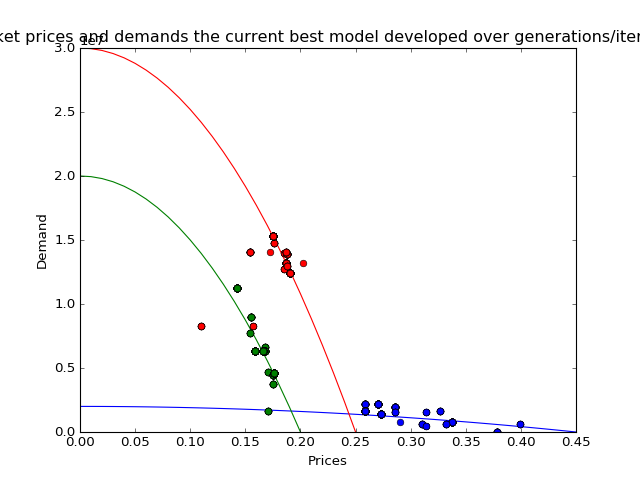

<IPython.core.display.Javascript object>


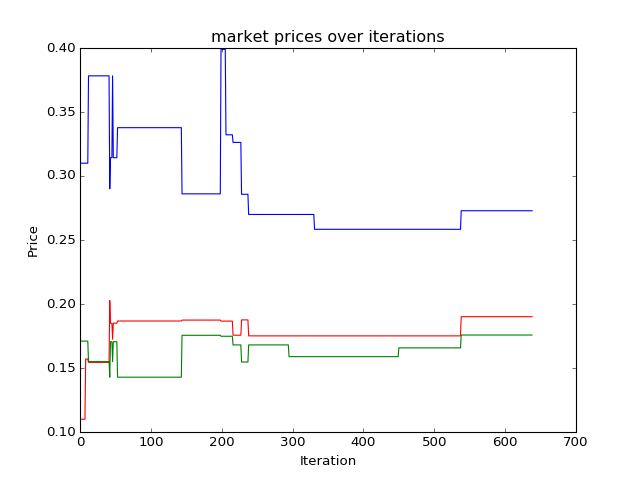

<IPython.core.display.Javascript object>


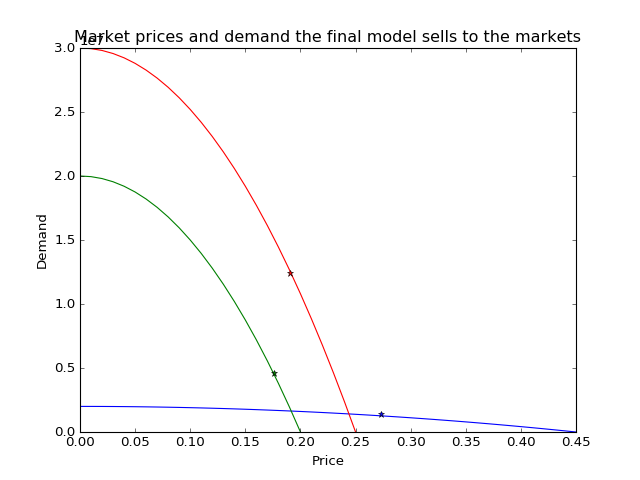

<IPython.core.display.Javascript object>


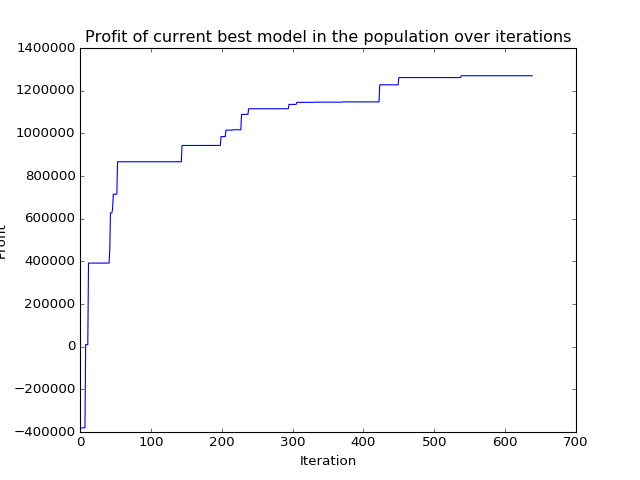

In [10]:
# Plotting code
prices1 = [row[6] for row in top_models]
prices2 = [row[7] for row in top_models]
prices3 = [row[8] for row in top_models]

demands1 = [row[3] for row in top_models]
demands2 = [row[4] for row in top_models]
demands3 = [row[5] for row in top_models]

# the demand function again. Doesn't work when it's in another cell.
def market_function(price, maxPrice, maxDemand):    
    # else determine demand based on price using this function
    demand = maxDemand - price**2 * maxDemand / maxPrice**2
    
    return demand

price_space1 = np.arange(0,p1*100+1)/100
price_space2 = np.arange(0,p2*100+1)/100
price_space3 = np.arange(0,p3*100+1)/100

# this one shows the prices and demands for each market over the generations/iterations.
plt.figure(1)
plt.plot(price_space1, [market_function(price,p1,d1) for price in price_space1], 'b-')
plt.plot(price_space2, [market_function(price,p2,d2) for price in price_space2], 'r-')
plt.plot(price_space3, [market_function(price,p3,d3) for price in price_space3], 'g-')

plt.plot(prices1,demands1, 'bo')
plt.plot(prices2,demands2, 'ro')
plt.plot(prices3,demands3, 'go')
plt.ylabel('Demand')
plt.xlabel('Prices')
plt.title('Market prices and demands the current best model developed over generations/iterations')

# general plot showing the development of the market prices the algorithm uses
plt.figure(2)
plt.plot(prices1)
plt.plot(prices2, color='red')
plt.plot(prices3, color='green')
plt.ylabel('Price')
plt.xlabel('Iteration')
plt.title('market prices over iterations')

# this plot shows the price-demand distribution of our best model from the final population
plt.figure(3)
plt.plot(price_space1, [market_function(price,p1,d1) for price in price_space1], 'b-')
plt.plot(price_space2, [market_function(price,p2,d2) for price in price_space2], 'r-')
plt.plot(price_space3, [market_function(price,p3,d3) for price in price_space3], 'g-')

best_model = top_models[-1]
plt.plot(best_model[6],best_model[3], 'b*')
plt.plot(best_model[7],best_model[4], 'r*')
plt.plot(best_model[8],best_model[5], 'g*')
plt.title('Market prices and demand the final model sells to the markets')
plt.ylabel('Demand')
plt.xlabel('Price')

# general plot showing the development of our profit.
plt.figure(4)
plt.plot(list_of_best)
plt.ylabel('Profit')
plt.xlabel('Iteration')
plt.title('Profit of current best model in the population over iterations')
plt.show()